[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/samgdotson/osier/env-instructions?labpath=docs%2Fsource%2Fexamples%2Fconstraint_tutorial.ipynb)

# Constraint Tutorial

In this tutorial, we will use `osier` to optimize the capacity for a test energy system using 
`osier`'s `CapacityExpansion` model and demonstrate converting an objective into a constraint.


**Important Caveat**

For simplicity and the sake of time, this notebook specifies a certain number of generations before the model terminates. Therefore it is unlikely that the capacity expansion models shown in this notebook are fully converged. These results should be used for instructional purposes only!

In [1]:
# basic imports
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW
import sys

# osier imports
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize


# set the solver based on operating system -- assumes glpk or cbc is installed.
if "win32" in sys.platform:
    solver = 'glpk'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cbc


As before, `osier` needs two fundamental things in order to run the model

1. A technology set
2. A net demand profile

Let's create both of these, first. This time, we'll also create a dummy "wind" profile and a wind technology to use in the latter two examples.
We'll also borrow some code from the dispatch tutorial.

## Creating the demand profile

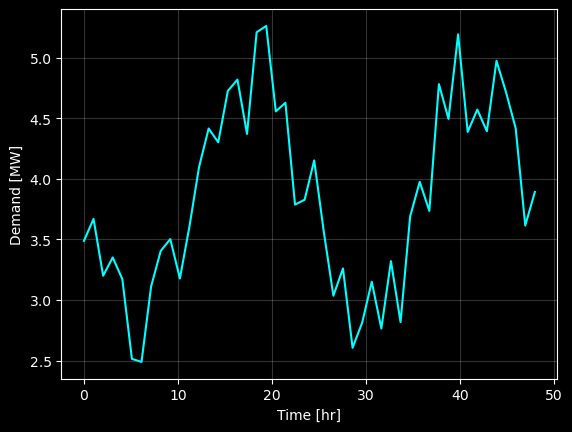

In [2]:
n_hours = 24  # hours per day
n_days = 2  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 185  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.grid(alpha=0.2)
    plt.show()

## Creating the "wind" profile

Wind speeds follow a Weibull distribution 

$f(v) = \left(\frac{k}{\lambda}\right)\left(\frac{v}{\lambda}\right)^{k-1}e^{-\left(\frac{v}{\lambda}\right)^k}$

Where $v$ is our random variable (velocity).

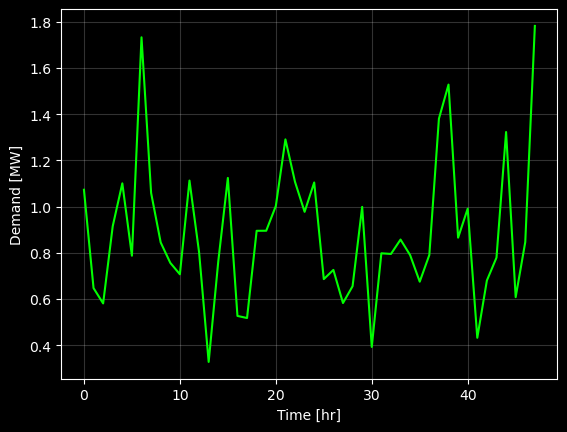

In [3]:
np.random.seed(123)
shape_factor = 2.5
wind_speed = np.random.weibull(a=shape_factor,size=N)

with plt.style.context('dark_background'):
    plt.plot(wind_speed, color='lime')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.show()
    

`osier.CapacityExpansion` will normalize the wind and solar profiles and rescale the maximum values to the rated capacity of the installed technology (for each "individual" portfolio tested). Just for fun, let's plot the "net demand" if this wind speed were the true value.

Also note that the weibull distribution is related to wind *speed*, not energy production. For simplicity, we will assume they're equal.

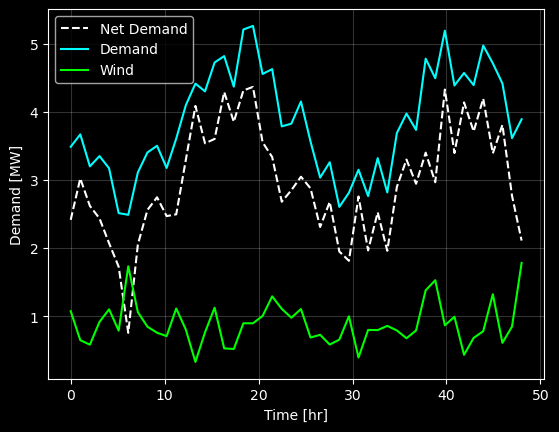

In [4]:
with plt.style.context('dark_background'):
    plt.plot(hours, demand-wind_speed, color='white', linestyle='--', label='Net Demand')
    plt.plot(hours, demand, color='cyan', label='Demand')
    plt.plot(hours, wind_speed, color='lime', label='Wind')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.legend()
    plt.show()

## Creating the Technology Mix

Let's try to meet demand with a properly sized wind turbine and storage combination.

In [5]:
technologies = [lib.wind, lib.natural_gas, lib.battery]
technologies

[WindTurbine: 0.0 MW,
 NaturalGas_Conv: 8375.1331 MW,
 Battery: 815.3412599999999 MW]

## Setting up the Capacity Expansion Problem

`osier.CapacityExpansion` inherits from a `pymoo.Problem` object. This class does not run the optimization itself, so we'll have to add the `pymoo` pieces later. Before we can instantiate the problem, though, we need to define the **objectives** to optimize over!

### Defining objectives

`osier` comes with a set of predefined objectives, such as cost and carbon emissions. Let's start with cost and carbon emissions.

In [6]:
from osier import annual_emission, total_cost

# the default emission is `lifecycle_co2_rate`

In [7]:
problem = CapacityExpansion(technology_list = technologies,
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [8]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      6 |             - |             -
     2 |       40 |      4 |  0.0158631600 |         nadir
     3 |       60 |      6 |  0.0046803095 |         nadir
     4 |       80 |     13 |  0.0075483249 |         ideal
     5 |      100 |     11 |  0.0286189133 |         ideal
     6 |      120 |     16 |  0.0143108618 |             f
     7 |      140 |     19 |  0.0038096293 |         ideal
     8 |      160 |     20 |  0.0123935101 |             f
     9 |      180 |     20 |  0.0488020532 |         nadir
    10 |      200 |     20 |  0.0176305024 |             f
The simulation took 1.072 minutes.


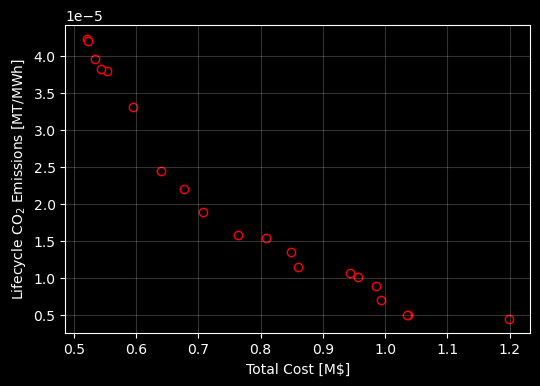

In [9]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()

## Converting an objective into a constraint

A popular strategy with other ESOMs is to apply a constraint to a variable like carbon emissions. Although this limits understanding of tradeoffs, this may be a viable approach if there is an existing policy objective that specifies a certain level of carbon emissions.

Instead of having two objectives, let's turn the ``annual_emission`` objective into a constraint! ``Osier`` reads constraints as a dictionary where the keys are the functions to calculate the constraint and the values are the limits to those constraints.

In [10]:
co2_limit = 2.5e-5
problem = CapacityExpansion(technology_list = technologies,
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost],
                            constraints= {annual_emission:co2_limit},
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [11]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res_constraint = minimize(problem,
                            algorithm,
                            termination=('n_gen', 10),
                            seed=1,
                            save_history=True,
                            verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       20 |      1 |  0.000000E+00 |  1.500000E+19 |             - |             -
     2 |       40 |      1 |  0.000000E+00 |  0.000000E+00 |  0.1000191518 |         ideal
     3 |       60 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |       80 |      1 |  0.000000E+00 |  0.000000E+00 |  0.1751703124 |         ideal
     5 |      100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0269796921 |         ideal
     6 |      120 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0409734359 |         ideal
     7 |      140 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0221669721 |         ideal
     8 |      160 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0035921908 |         ideal

Let's run the results through a dispatch model to calculate the final carbon emissions.

In [12]:
from osier import DispatchModel

technology_list = []
for X,tech in zip(res_constraint.X,problem.technology_list):
    tech.capacity = X*problem.max_demand
    technology_list.append(tech)
display(technology_list)
# normalize the wind speed
wind_speed = (wind_speed / wind_speed.max()) * res_constraint.X[0]*problem.max_demand
net_dem = demand*MW - wind_speed
display(f"Max wind production: {wind_speed.max()}")

model = DispatchModel(technology_list=technology_list[1:],
                      net_demand=net_dem)
model.solve(solver=solver)

[WindTurbine: 6.333350714536953 MW,
 NaturalGas_Conv: 2.8132440242425973 MW,
 Battery: 0.5889705432873401 MW]

'Max wind production: 6.333350714536953 MW'

In [13]:
model.results = pd.concat([pd.DataFrame({'WindTurbine':wind_speed}), model.results], axis=1)

In [14]:
lifecycle_co2 = annual_emission(technology_list=technology_list,
                solved_dispatch_model = model)

### Let's plot this value against our Pareto front from earlier!

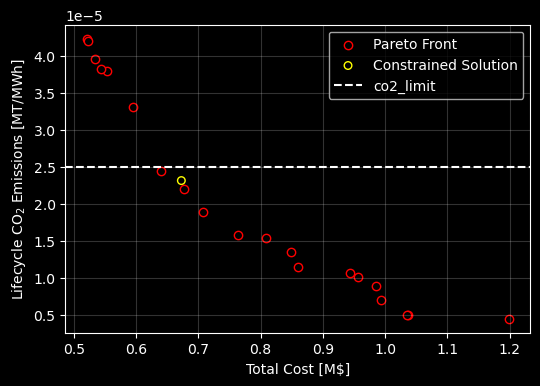

In [15]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k', label='Pareto Front')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    ax.scatter(res_constraint.F[0], lifecycle_co2, edgecolors='yellow', facecolors='None', s=30, label='Constrained Solution')
    ax.axhline(y=co2_limit, label='co2_limit', color='white', linestyle='--')
    ax.legend()

    plt.show()

### Analysis

1. Only one solution is shown, here, since we simply converted the objective in a constraint and performed a single objective optimization.
2. This example shows that ``Osier`` respects constraints (though ``Pymoo`` is "greedy" and minimizes the constraint violation (CV) rather than strictly honoring a constraint).
3. The existence of a lower total cost and slightly higher CO$_2$ solution on the Pareto Front suggests that the simpler model is not fully converged (although, neither of the models can be considered "fully converged" since they used a small number of generations).

## Applying two objectives and a constraint

If we still wanted to see some tradeoff while applying a constraint to one of them -- we can! The next example demonstrates this.

In [16]:
co2_limit = 2.5e-5
problem = CapacityExpansion(technology_list = technologies,
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            constraints= {annual_emission:co2_limit},
                            solver=solver) # the objectives must be passed as a LIST of functions!

In [17]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res_constraint_2 = minimize(problem,
                            algorithm,
                            termination=('n_gen', 10),
                            seed=1,
                            save_history=True,
                            verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       20 |      5 |  0.000000E+00 |  1.500000E+19 |             - |             -
     2 |       40 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0654705631 |             f
     3 |       60 |      7 |  0.000000E+00 |  0.000000E+00 |  0.2485795005 |         ideal
     4 |       80 |     10 |  0.000000E+00 |  0.000000E+00 |  0.3049179277 |         nadir
     5 |      100 |     11 |  0.000000E+00 |  0.000000E+00 |  1.3721450111 |         nadir
     6 |      120 |     11 |  0.000000E+00 |  0.000000E+00 |  0.5801153169 |         nadir
     7 |      140 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0247543877 |         nadir
     8 |      160 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0367281977 |         ideal
     9 |      180 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0147077342 |             f
    10 |      200 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0072011434 |         nadir

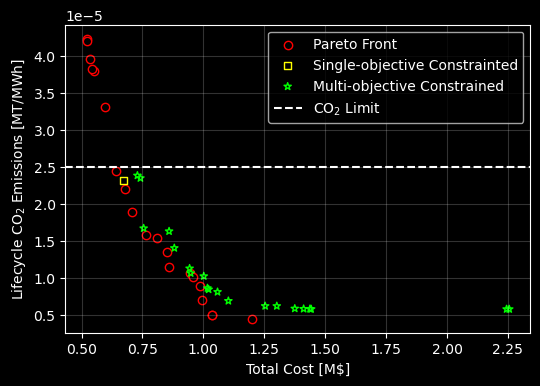

In [18]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k', label='Pareto Front')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    ax.scatter(res_constraint.F[0], lifecycle_co2, edgecolors='yellow', 
               facecolors='None', marker='s', s=30, label='Single-objective Constrainted')
    ax.scatter(res_constraint_2.F[:,0], res_constraint_2.F[:,1], 
               edgecolors='lime', facecolors='None', marker='*', s=30, label='Multi-objective Constrained')
    ax.axhline(y=co2_limit, label='CO$_2$ Limit', color='white', linestyle='--')
    ax.legend()

    plt.show()

### Analysis

Once again, it looks like the constrained model is not quite as "converged" as the unconstrained model since the latter shows some cheaper and lower emissions solutions. The example further illustrates how ``Osier`` can use "objective" functions as objectives and/or constraints!